Installing essential packages

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.8 MB/s 
     |████████████████████████████████| 7.6 MB 77.7 MB/s 
     |████████████████████████████████| 182 kB 91.4 MB/s 


In [2]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 8.5 MB/s 


In [3]:
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import random, pickle
import numpy as np
from torch.nn import BCEWithLogitsLoss, BCELoss
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import torch
import pandas as pd
from torchmetrics.classification import MultilabelF1Score

from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForSequenceClassification

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import copy
from sklearn.utils import shuffle
import glob

import time
import datetime

import pandas as pd
import numpy as np
import io

In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: A100-SXM4-40GB


In [6]:

from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [7]:
path = "/content/gdrive/MyDrive/BIA667_FinalProject/train.csv"

In [8]:
# from google.colab import files
 
 
# uploaded = files.upload()

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

In [10]:
train_df = pd.read_csv(path)
# train_df = pd.read_csv('C:/Users/Admin/Documents/Stevens Docs/BIA 656/Project/train.csv')

Preprocessing data i.e is removing spec characters from the ttext so we have only words in the document

In [13]:
train_df['document_text']= train_df['document_text'].str.lower()
train_df['name']= train_df['name'].str.lower()

In [14]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    train_df['document_text'] = train_df['document_text'].str.replace(char, ' ')
    train_df['name'] = train_df['name'].str.replace(char, ' ')

<ipython-input-14-4b1c388cc09c>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_df['document_text'] = train_df['document_text'].str.replace(char, ' ')
<ipython-input-14-4b1c388cc09c>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_df['name'] = train_df['name'].str.replace(char, ' ')


In [15]:
df2 = train_df.groupby(['name','document_text'])['cat_name'].apply(list)
df3=df2.to_frame().reset_index()

In [16]:
df3['comb_name_doctext'] = df3['name'] + df3['document_text'].apply(lambda x: '. ' + x)

In [17]:
df3.head()

,name,document_text,cat_name,comb_name_doctext
0,correction to symbol information regarding t...,qutoutiao inc qtt will effect a one for ten...,[Broker Dealer],correction to symbol information regarding t...
1,digital health 2020 eu on the move wojci...,european data protection supervisor published ...,"[Research, Natural Disasters, Powers and Dutie...",digital health 2020 eu on the move wojci...
2,updated correction to merger consideration ...,the business combination of quidel corp qdel ...,"[Broker Dealer, Corporate Communications]",updated correction to merger consideration ...
3,updated information regarding the business c...,the business combination of twc tech holdings ...,"[Forms, Listing, Broker Dealer, Securities Set...",updated information regarding the business c...
4,updated closed information regarding the bus...,the business combination of mountain crest acq...,"[Broker Dealer, Corporate Communications]",updated closed information regarding the bus...


In [18]:
len(df3)

9263

Converting cat_name to array of binary class variables

In [19]:
mlb = MultiLabelBinarizer()
labels = df3['cat_name'].values
label_onehot = mlb.fit_transform(labels)

BERT for pretrained word vectors

In [20]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


tokenizer = AutoTokenizer.from_pretrained(
        "nlpaueb/legal-bert-base-uncased"

    )


Loading BERT tokenizer...


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [21]:

bert_model = AutoModel.from_pretrained(
   # "bert-base-uncased",
   "nlpaueb/legal-bert-base-uncased",
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
        
    )
bert_model.cuda()


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def get_pretrained_word_vectors(sentences, tokenizer, bert_model):
    """
    Obtain the pretrained word vectors for the given sentences using a BERT model.

    Parameters:
        - sentences (list): List of sentences to process
        - tokenizer (object): Tokenizer object to use for encoding the sentences
        - bert_model (object): BERT model to use for generating the word vectors

    Returns:
        - token_embeddings (list): List of token embeddings for the input sentences
        - attention_masks (torch.Tensor): Tensor of attention masks for the input sentences
        - input_ids (torch.Tensor): Tensor of input IDs for the input sentences
    """
    input_ids = []
    attention_masks = []

    # Tokenize each sentence and create input IDs and attention masks
    for sent in sentences:
        # Tokenize and create special tokens, pad or truncate, and create attention mask
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=400,  # Pad & truncate all sentences
            truncation=True,
            padding='max_length',
            return_attention_mask=True,  # Construct attention masks
            return_tensors='pt',  # Return pytorch tensors
        )

        # Append the encoded sentence and attention mask to the lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Create a TensorDataset and DataLoader for the input IDs and attention masks
    dataset = TensorDataset(input_ids, attention_masks)
    data_loader = DataLoader(dataset, batch_size=8, num_workers=2)

    token_embeddings = []

    # Set the model to evaluation mode
    bert_model.eval()
    with torch.no_grad():
        # Iterate over the data in the data loader
        for input_id, attention_mask in data_loader:
            # Get the hidden states of the model for the input IDs and attention masks
            outputs = bert_model(input_id.to(device), attention_mask.to(device))
            hidden_states = outputs[2]

            # Stack the last four hidden states and permute the dimensions
            emb = torch.stack(hidden_states[-4:], dim=0)
            emb = emb.permute(1, 2, 0, 3)

            # Take the mean of the last four hidden states along the third dimension
            emb = emb.mean(axis=2)

            # Append the token embeddings to the list
            # Append the token embeddings to the list
            token_embeddings.append(emb)

    return token_embeddings, attention_masks, input_ids

In [24]:
token_embeddings, masks, input_ids = get_pretrained_word_vectors(df3['comb_name_doctext'], tokenizer, bert_model)

In [25]:
token_embeddings_splice = np.array([j.cpu().numpy() for i in token_embeddings for j in i])
token_embeddings_masked = (masks.view(-1, 400, 1) * token_embeddings_splice)


Dividing the data into train and test set with Y labels

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(token_embeddings_masked, label_onehot, test_size=0.2, random_state=1)


In [28]:
from torch.utils.data import TensorDataset, random_split, Dataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

Creating Custom Dataset for it to be used in Neural Network

In [29]:
class Text_dataset(Dataset):
    def __init__(self, features, labels):
        self.length = len(labels)
        self.features = torch.Tensor(features)
        self.labels = torch.Tensor(labels)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
    def __len__(self):
        return self.length        

In [30]:
# datasets
train_dataset = Text_dataset(X_train, Y_train)
test_dataset = Text_dataset(X_test, Y_test)

In [31]:
train_dataset.features.size()

torch.Size([7410, 400, 768])

Defining the RNN Model class which has unigram,bigram,trigram and classifier layers

In [32]:
class TextRNN(nn.Module):
    def __init__(self, DOC_LEN, embedding_dim, dropout_ratio):
        super(TextRNN, self).__init__()
        self.dropout_ratio = dropout_ratio
        in_channels = 400
        out_channels = 600
        bias = False

        # reduce the length
        self.reduce = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=in_channels),
            # nn.Dropout(dropout_ratio),
            nn.ReLU()
        )

        # unigram RNN
        self.unigram = nn.GRU(input_size=in_channels, hidden_size=out_channels, num_layers=1, batch_first=True)

        # bigram RNN
        self.bigram = nn.GRU(input_size=in_channels, hidden_size=out_channels, num_layers=1, batch_first=True)

        # trigram RNN
        self.trigram = nn.GRU(input_size=in_channels, hidden_size=out_channels, num_layers=1, batch_first=True)

        # simple classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=out_channels*3, out_features=50)
        )

    def forward(self, x):
        # reduce length
        x = self.reduce(x)
        # print(x.shape)
        x = torch.transpose(x, dim0=1, dim1=2)  # (-1, DOC_LEN, embedding_dim): embedding on 1(DOC_LEN) & 2(embedding_dim) dims
        # print(x.shape)
        # unigram RNN output
        uni_gram_output, _ = self.unigram(x)
        uni_gram_output = uni_gram_output[:, -1, :]

        # bigram RNN output
        bi_gram_output, _ = self.bigram(x)
        bi_gram_output = bi_gram_output[:, -1, :]

        # trigram RNN output
        tri_gram_output, _ = self.trigram(x)
        tri_gram_output = tri_gram_output[:, -1, :]

        # concatenate
        x = torch.cat((uni_gram_output, 
                       bi_gram_output, 
                       tri_gram_output
                       ), dim=1)
        # classifier
        x = self.classifier(x)

        return x

In [33]:
model_RNN=TextRNN(400,768,0.5)

In [34]:
# Compute weights to handle imbalanced classes
class_counts = Y_train.sum(axis=0)
weights = [1/count for count in class_counts]
weights = [weight/sum(weights) for weight in weights]
weights = torch.Tensor(weights).to(device)

Defining train function for the model

In [35]:
def train_model(model, train_dataset, test_dataset, device, lr=0.0001, epochs=20, batch_size=32):
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    test_pred = DataLoader(test_dataset, batch_size=len(test_dataset))

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_f1': [],
               'test_loss': [],
               'test_f1': []
               }

    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    metric = MultilabelF1Score(num_labels=50).to(device)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_f1 = 0
        test_loss = 0
        test_f1 = 0
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x.float())
            pred = torch.round(torch.sigmoid(outputs))
            cur_train_loss = criterion(outputs, y)
            cur_train_loss = (cur_train_loss * weights).mean()*100
            cur_train_f1 = metric(pred, y)
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_f1 += cur_train_f1

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x.float())
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y).mean()
                cur_test_loss = (cur_train_loss * weights).mean()*100
                cur_test_f1 = metric(pred, y)
                # loss and acc
                test_loss += cur_test_loss
                test_f1 += cur_test_f1

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_f1 = (train_f1/len(train_loader)).item()
        val_loss = (test_loss/len(test_loader)).item()
        val_f1 = (test_f1/len(test_loader)).item()
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['test_loss'].append(val_loss)
        history['test_f1'].append(val_f1)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f} train f1:{train_f1:.4f}, valid loss:{val_loss:.4f} valid f1:{val_f1:.4f}")


    with torch.no_grad():
        for x, y in test_pred:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x.float())
            pred = torch.round(torch.sigmoid(outputs))
            preds = pred.cpu().detach().numpy()

    return history, preds

In [36]:
history, preds = train_model(model=model_RNN,
                             train_dataset=train_dataset,
                             test_dataset=test_dataset,
                             device=device,
                             lr=0.0005,
                             epochs=40,
                             batch_size=128)

Training Start
Epoch:1 / 40, train loss:0.6253 train f1:0.0038, valid loss:1.1084 valid f1:0.0000
Epoch:2 / 40, train loss:0.5372 train f1:0.0049, valid loss:0.9878 valid f1:0.0096
Epoch:3 / 40, train loss:0.4938 train f1:0.0622, valid loss:0.9451 valid f1:0.1249
Epoch:4 / 40, train loss:0.4658 train f1:0.1375, valid loss:0.8998 valid f1:0.1615
Epoch:5 / 40, train loss:0.4440 train f1:0.1906, valid loss:0.9001 valid f1:0.1959
Epoch:6 / 40, train loss:0.4225 train f1:0.2403, valid loss:0.8345 valid f1:0.2467
Epoch:7 / 40, train loss:0.4011 train f1:0.3019, valid loss:0.7973 valid f1:0.2943
Epoch:8 / 40, train loss:0.3804 train f1:0.3566, valid loss:0.7716 valid f1:0.3578
Epoch:9 / 40, train loss:0.3592 train f1:0.4102, valid loss:0.6918 valid f1:0.3873
Epoch:10 / 40, train loss:0.3423 train f1:0.4531, valid loss:0.7030 valid f1:0.3948
Epoch:11 / 40, train loss:0.3221 train f1:0.4983, valid loss:0.6898 valid f1:0.4171
Epoch:12 / 40, train loss:0.3038 train f1:0.5337, valid loss:0.6222 va

Plot for F1 score for RNN model

[]

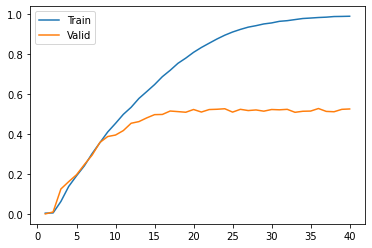

In [37]:
import matplotlib.pyplot as plt
plt.plot(range(1, 41), history['train_f1'], label='Train')
plt.plot(range(1, 41), history['test_f1'], label='Valid')
plt.legend()
plt.plot()

In [38]:
#ModelRNN
from sklearn.metrics import classification_report

print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.60      0.41      0.49       191
           1       0.79      0.64      0.71       171
           2       0.55      0.49      0.52       194
           3       0.67      0.48      0.56       134
           4       0.74      0.67      0.70       104
           5       0.67      0.46      0.54       264
           6       0.69      0.39      0.49       187
           7       0.78      0.58      0.67       219
           8       0.70      0.29      0.41       112
           9       0.56      0.26      0.36       177
          10       0.34      0.20      0.25       102
          11       0.81      0.62      0.70       147
          12       0.66      0.46      0.54       344
          13       0.53      0.37      0.43       229
          14       0.55      0.51      0.53       223
          15       0.62      0.43      0.51       109
          16       0.74      0.60      0.66       218
          17       0.76    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Defining advanced model with CNN with unigram,bigram,trigram,quadgram,pentagram and one convolution layer with max pooling

In [39]:
class TextCNN(nn.Module):
    def __init__(self, DOC_LEN, embedding_dim, dropout_ratio):
        super(TextCNN, self).__init__()
        self.DOC_LEN = DOC_LEN
        self.in_channels = 400
        self.out_channels = 600
        self.bias = False

        # reduce the length
        self.reduce_length = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=self.in_channels),
            nn.ReLU()
        )

        # 1D CNNs for unigrams, bigrams, trigrams, quadgrams, and pentagrams
        self.unigram_cnn = self._build_1d_cnn(kernel_size=1)
        self.bigram_cnn = self._build_1d_cnn(kernel_size=2)
        self.trigram_cnn = self._build_1d_cnn(kernel_size=3)
        self.quadgram_cnn = self._build_1d_cnn(kernel_size=4)
        self.pentagram_cnn = self._build_1d_cnn(kernel_size=5)

        # simple classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=self.out_channels*5, out_features=50)
        )

    def _build_1d_cnn(self, kernel_size):
        """Helper function to build 1D CNN layers for a given kernel size."""
        return nn.Sequential(
            nn.Conv1d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=kernel_size, bias=self.bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=self.DOC_LEN - kernel_size + 1),
            nn.Flatten()
        )

    def forward(self, x):
        # reduce length
        x = self.reduce_length(x)
        x = torch.transpose(x, dim0=1, dim1=2)  # (-1, DOC_LEN, embedding_dim)

        # 1D CNN outputs
        unigram_output = self.unigram_cnn(x)
        bigram_output = self.bigram_cnn(x)
        trigram_output = self.trigram_cnn(x)
        quadgram_output = self.quadgram_cnn(x)
        pentagram_output = self.pentagram_cnn(x)

        # concatenate 1D CNN outputs
        x = torch.cat((unigram_output, bigram_output, trigram_output, quadgram_output, pentagram_output), dim=1)

        # classifier

        x = self.classifier(x)

        return x

In [40]:
model_CNN=TextCNN(400,768,0.5)

In [41]:
history, preds = train_model(model=model_CNN,
                             train_dataset=train_dataset,
                             test_dataset=test_dataset,
                             device=device,
                             lr=0.0005,
                             epochs=40,
                             batch_size=128)

Training Start
Epoch:1 / 40, train loss:0.5925 train f1:0.0026, valid loss:1.0962 valid f1:0.0000
Epoch:2 / 40, train loss:0.5010 train f1:0.0495, valid loss:0.8874 valid f1:0.1518
Epoch:3 / 40, train loss:0.4129 train f1:0.2651, valid loss:0.8092 valid f1:0.3788
Epoch:4 / 40, train loss:0.3421 train f1:0.4463, valid loss:0.6782 valid f1:0.5184
Epoch:5 / 40, train loss:0.2919 train f1:0.5603, valid loss:0.5135 valid f1:0.6041
Epoch:6 / 40, train loss:0.2566 train f1:0.6342, valid loss:0.4853 valid f1:0.6382
Epoch:7 / 40, train loss:0.2315 train f1:0.6801, valid loss:0.4338 valid f1:0.6796
Epoch:8 / 40, train loss:0.2086 train f1:0.7119, valid loss:0.3959 valid f1:0.6945
Epoch:9 / 40, train loss:0.1907 train f1:0.7413, valid loss:0.3563 valid f1:0.7316
Epoch:10 / 40, train loss:0.1748 train f1:0.7681, valid loss:0.3440 valid f1:0.7205
Epoch:11 / 40, train loss:0.1610 train f1:0.7883, valid loss:0.3082 valid f1:0.7485
Epoch:12 / 40, train loss:0.1480 train f1:0.8048, valid loss:0.3221 va

Classification Report for CNN with accuracy of 81%

In [42]:
#ModelCNN
from sklearn.metrics import classification_report

print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.70      0.80       191
           1       0.97      0.78      0.87       171
           2       0.94      0.83      0.88       194
           3       0.97      0.85      0.90       134
           4       0.93      0.88      0.91       104
           5       0.92      0.88      0.90       264
           6       0.92      0.78      0.85       187
           7       0.91      0.83      0.86       219
           8       0.87      0.64      0.74       112
           9       0.85      0.54      0.66       177
          10       0.91      0.69      0.78       102
          11       0.92      0.79      0.85       147
          12       0.83      0.65      0.73       344
          13       0.94      0.86      0.89       229
          14       0.98      0.94      0.96       223
          15       0.96      0.85      0.90       109
          16       0.97      0.78      0.87       218
          17       0.86    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
